![rmotr](https://www.wingoo-solutions.fr/194/105-logo-asi.gif)
<hr style="margin-bottom: 20px;">

# Rapport sur l'accidentalité en france
#### Source: Ministère de l'intérieur sur data.gouv.fr
<hr style="margin-bottom: 20px;">

In [1]:
## Librairies utilisées
import pandas as pd , glob, numpy as np, matplotlib.pyplot as plt, statsmodels.api as sm
import ipywidgets as widgets, cufflinks as cf
from tabulate import tabulate
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # Import train_test_split function
from sklearn import metrics, tree #Import scikit-learn metrics module for accuracy calculation
from sklearn.impute import SimpleImputer
from graphviz import Source
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from ipywidgets import interact, interact_manual
import matplotlib
import ipywidgets as widget

## Importer les données, jointures et nettoyage (Data preparation)

#### Lécture et jointure des fichiers

In [2]:
# Fichiers caracteristiques
all_files_caracteristiques = glob.glob(r'C:\DataSources\caracteristiques' + "/*.csv") # Lister les fichiers contenus dans le path
li_caracteristiques = [] # Initialiser la lister de lécture
for filename in all_files_caracteristiques: # Boucler sur les fichiers en les lisant
    df = pd.read_csv(filename, index_col=None, header=0, encoding = "latin") # Bien spécifier encoding = "latin"
    li_caracteristiques.append(df) 
frame_caracteristiques = pd.concat(li_caracteristiques, axis=0, ignore_index=True) # Créer un dataframe à partir de la liste des fichiers lus
print('====== {} lignes importées à partir des fichiers de caracteristiques'.format(frame_caracteristiques['Num_Acc'].count()))


# Lecture lieux 
all_files_lieux = glob.glob(r'C:\DataSources\lieux' + "/*.csv")
li_lieux = []
for filename in all_files_lieux:
    df = pd.read_csv(filename, index_col=None, header=0, encoding = "latin", sep=',', low_memory=False)
    li_lieux.append(df)
frame_lieux = pd.concat(li_lieux, axis=0, ignore_index=True)
print('====== {} lignes importées à partir des fichiers de lieux'.format(frame_lieux['Num_Acc'].count()))

# Lecture usagers 
all_files_usagers = glob.glob(r'C:\DataSources\usagers' + "/*.csv")
li_usagers = []
for filename in all_files_usagers:
    df = pd.read_csv(filename, index_col=None, header=0, encoding = "latin", sep=',', low_memory=False)
    li_usagers.append(df)
frame_usagers = pd.concat(li_usagers, axis=0, ignore_index=True)
print('====== {} lignes importées à partir des fichiers de usagers'.format(frame_usagers['Num_Acc'].count()))

#### Jointure des accidents
frame_accident = pd.merge(frame_caracteristiques, frame_lieux, on = 'Num_Acc')
df_acc_usr = pd.merge(frame_accident, frame_usagers, on = 'Num_Acc')
df_acc_usr['grav'] = df_acc_usr['grav'].map(lambda x: 1 if x == 2 else 0 )  # Accident morte = 1 autre accident = 0
print(f'====== Jointure des dataframe caracteristiques, lieux et usagers \n')

====== 958469 lignes importées à partir des fichiers de caracteristiques
====== 958469 lignes importées à partir des fichiers de lieux
====== 2142195 lignes importées à partir des fichiers de usagers
====== Jointure des dataframe caracteristiques, lieux et usagers 



#### Premier nettoyage des données

##### Mise en forme de la date

In [3]:
# Mise en forme de la date
## ¨pit avoir toutes les années tout format de quatre charactères. Ex: ( 5 -> 005 -> 05 -> 2005)  , (16 -> 0016, 16 -> 2016)
df_acc_usr['an']  = '20' + ('00' + df_acc_usr['an'].map(str) ).str[-2:]

## Pour avoir tout les mois sous format de deux charactères. Ex: ( 1 -> 001 -> 01) , (13 -> 0013 -> 13)
df_acc_usr['mois']  = ('00' + df_acc_usr['mois'].map(str)).str[-2:]

## Pour avoir tout les jours sous format de deux charactères. Ex: ( 3 -> 003 -> 03) , (15 -> 0015 -> 15)
df_acc_usr['jour']  = ('00' + df_acc_usr['jour'].map(str) ).str[-2:]

## Pour avoir tout les jours sous format de quatre charactères. Ex: ( 3 -> 003 -> 003) , (1250 -> 001250 -> 1250) , (230 -> 00230 -> 0230)
df_acc_usr['hrmn']  = ('00' + df_acc_usr['hrmn'].map(str) ).str[-4:]

## Ajout de la colonne Date
df_acc_usr['Date'] = pd.to_datetime(df_acc_usr['an'] + df_acc_usr['mois'] + df_acc_usr['jour'] + df_acc_usr['hrmn'] , format='%Y%m%d%H%M')
print(df_acc_usr['Date'].head(5))

0   2017-01-11 18:20:00
1   2017-01-11 18:20:00
2   2017-01-11 18:20:00
3   2017-02-13 16:30:00
4   2017-02-13 16:30:00
Name: Date, dtype: datetime64[ns]


##### Calculs des ages

In [4]:
df_acc_usr['age'] = ( np.int64(df_acc_usr['an']) - df_acc_usr['an_nais'] )
print(df_acc_usr['age'].head(5))

0    49.0
1    44.0
2    50.0
3    64.0
4    57.0
Name: age, dtype: float64


##### Supression des colonnes non utilisées

In [5]:
# Supression des colonnes inutiles
df_acc_usr = df_acc_usr.drop(['an', 'mois', 'jour', 'hrmn', 'com', 'adr'
                 , 'gps', 'lat', 'long', 'dep', 'an_nais', 'num_veh'], axis=1)

##### Changement des types de données

In [6]:
df_acc_usr = df_acc_usr.astype({
    'lum': 'category', 'agg': 'category', 'int': 'category', 
    'atm': 'category', 'col': 'category', 'catr': 'category',
    'circ': 'category', 'vosp': 'category', 'prof': 'category',
    'plan': 'category', 'surf': 'category', 'infra': 'category', 
    'situ': 'category', 'env1': 'category', 'place': 'category', 
    'catu': 'category', 'grav': 'category', 'sexe': 'category', 
    'trajet': 'category', 'secu': 'category', 'locp': 'category', 
    'actp': 'category', 'etatp': 'category'
})

### Analyser la donnée (Data exploration)

#### Aperçu des données

In [7]:
df_acc_usr.describe(percentiles=None, include='category')

,lum,agg,int,atm,col,catr,circ,vosp,prof,plan,...,env1,place,catu,grav,sexe,trajet,secu,locp,actp,etatp
count,2142195,2142195,2142195,2142046.0,2142152.0,2142193.0,2138626.0,2135842.0,2137752.0,2136789.0,...,2129477.0,2019067.0,2142195,2142195,2142195,2141701.0,2085658.0,2085834.0,2085733.0,2085777.0
unique,5,2,10,9.0,7.0,8.0,5.0,4.0,5.0,5.0,...,3.0,10.0,4,2,2,7.0,24.0,9.0,8.0,4.0
top,1,2,1,1.0,3.0,4.0,2.0,0.0,1.0,1.0,...,0.0,1.0,1,0,1,5.0,11.0,0.0,0.0,0.0
freq,1476913,1409485,1508764,1731553.0,646254.0,1020816.0,1348599.0,2004172.0,1630969.0,1653317.0,...,1210476.0,1596108.0,1594260,2084614,1439318,796393.0,1197467.0,1923108.0,1913376.0,1914793.0


In [8]:
df_acc_usr.describe(percentiles=None, exclude=['category', 'datetime', 'object'])

,Num_Acc,v1,nbv,pr,pr1,lartpc,larrout,age
count,2.142195e+06,750230.000000,2.135950e+06,1.121537e+06,1.117644e+06,2.014575e+06,2.018811e+06,2.139777e+06
mean,2.010923e+11,0.079216,2.107546e+00,9.236276e+01,2.899833e+02,5.575486e+00,5.985202e+01,3.748199e+01
std,4.081452e+08,0.608558,1.528709e+00,4.428746e+02,3.586551e+02,2.332773e+01,6.585246e+01,1.826791e+01
min,2.005000e+11,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.100000e+01,0.000000e+00
25%,2.007001e+11,0.000000,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01
50%,2.011000e+11,0.000000,2.000000e+00,7.000000e+00,1.450000e+02,0.000000e+00,6.000000e+01,3.400000e+01
75%,2.014001e+11,0.000000,2.000000e+00,3.000000e+01,5.000000e+02,0.000000e+00,8.000000e+01,5.000000e+01
max,2.018001e+11,9.000000,9.900000e+01,9.929000e+03,9.540000e+03,9.600000e+02,9.990000e+02,1.090000e+02


#### Verifier le taux de valeurs manquantes

In [9]:
df_missing_values = pd.DataFrame(df_acc_usr.isnull().sum())[0]
df_missing_values = pd.DataFrame({'colonne':df_missing_values.index, 'nbr_manquant':df_missing_values.values})
nbr_lignes = df_acc_usr['Num_Acc'].count()
df_missing_values["%_missing"] = ((df_missing_values['nbr_manquant'] / nbr_lignes )* 100 ).round(decimals=2)

In [10]:
df_missing_values

,colonne,nbr_manquant,%_missing
0,Num_Acc,0,0.00
1,lum,0,0.00
2,agg,0,0.00
3,int,0,0.00
4,atm,149,0.01
5,col,43,0.00
6,catr,2,0.00
7,voie,187064,8.73
8,v1,1391965,64.98
9,v2,2050561,95.72


#### Supression des colonnes inutilisées

In [11]:
df_acc_usr = df_acc_usr.drop(['v1', 'v2', 'pr', 'pr1', 'voie', 'larrout', 'lartpc'
               , 'nbv', 'locp', 'secu', 'actp', 'etatp'] , axis=1)

#### Imputation des valeurs manquantes

In [12]:
# Remplacer les valeurs manquantes de l'age par la moyenne
df_acc_usr['age'].fillna(df_acc_usr['age'].mean(), inplace=True)

# Je n'ai pas pu remplacer les valeurs manquantes des attribtuts quali de la même façon à cause d'un bug panda https://github.com/pandas-dev/pandas/issues/35731
# J'ai utilisé l'imputer de sklearner à la place
imp = SimpleImputer(strategy='most_frequent')
imputed_df_acc_usr = imp.fit_transform(df_acc_usr)

# De l'imputation résulte un numpy_darray, il faudra le transformer en dataframe pour continuer les analyses
imputed_df_acc_usr = pd.DataFrame(imputed_df_acc_usr, columns=['Num_Acc', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp',
                                                       'prof', 'plan', 'surf', 'infra', 'situ', 'env1', 'place', 'catu',
                                                       'grav', 'sexe', 'trajet', 'Date', 'age'])

# Verifier que toutes les valeurs manquantes ont été remplacées
df_missing_values = pd.DataFrame(imputed_df_acc_usr.isnull().sum())[0]
df_missing_values = pd.DataFrame({'colonne':df_missing_values.index, 'nbr_manquant':df_missing_values.values})
nbr_lignes = df_acc_usr['Num_Acc'].count()
df_missing_values["%_missing"] = ((df_missing_values['nbr_manquant'] / nbr_lignes )* 100 ).round(decimals=2)


In [13]:
imputed_df_acc_usr.head(5)

,Num_Acc,lum,agg,int,atm,col,catr,circ,vosp,prof,...,infra,situ,env1,place,catu,grav,sexe,trajet,Date,age
0,201700000001,5,2,1,1,1,3,2,2,1,...,0,1,99,1,1,0,1,9,2017-01-11 18:20:00,49
1,201700000001,5,2,1,1,1,3,2,2,1,...,0,1,99,2,2,0,2,9,2017-01-11 18:20:00,44
2,201700000001,5,2,1,1,1,3,2,2,1,...,0,1,99,1,1,0,1,1,2017-01-11 18:20:00,50
3,201700000002,1,2,3,1,3,3,2,0,1,...,0,1,0,1,1,0,1,0,2017-02-13 16:30:00,64
4,201700000002,1,2,3,1,3,3,2,0,1,...,0,1,0,1,1,0,1,5,2017-02-13 16:30:00,57


### Création des dataframes utilisés pour les analyses

In [14]:
AccidentDates = df_acc_usr['Date']
AccidentByYear = AccidentDates.groupby([df_acc_usr['Date'].dt.year.rename('annee')]).agg({'count'})
AccidentByYear.head(5)

,count
annee,
2005,197498
2006,187085
2007,188457
2008,170960
2009,165962


In [15]:
AccidentByMonth = pd.DataFrame({'Date' :  df_acc_usr['Date']  , 'Accidents' : 1})
AccidentByMonth['year_month'] = pd.to_datetime(((AccidentByMonth['Date'].dt.year).map(str) + 
                                                (AccidentByMonth['Date'].dt.month).map(str)) , 
                                               format='%Y%m')
AccidentByMonth = AccidentByMonth.groupby('year_month' , as_index=False)['Accidents'].sum()

AccidentByMonth['annee'] = AccidentByMonth['year_month'].dt.year
AccidentByMonth['mois'] = AccidentByMonth['year_month'].dt.month_name()
del AccidentByMonth['year_month']
AccidentByMonth_pivoted = AccidentByMonth.pivot(index='mois', columns='annee', values='Accidents')
AccidentByMonth

,Accidents,annee,mois
0,16403,2005,January
1,12782,2005,February
2,14792,2005,March
3,14892,2005,April
4,17792,2005,May
...,...,...,...
163,10096,2018,August
164,12456,2018,September
165,12678,2018,October
166,10856,2018,November


## Machin learning

### Prédiction de le gravité de l'accident par arbre de décision

In [16]:
# Choix des colonnes à utiliser pour la prédiction
feature_cols = list(df_acc_usr.columns) # Lister toutes les colonnes
feature_cols.remove('Num_Acc') # Colonne non utilisée
feature_cols.remove('Date') # Colonne non utilisée
feature_cols.remove('grav') # Colonne non utilisée
feature_cols.remove('env1')  # Colonne non utilisée

# DF des observations
X = imputed_df_acc_usr[feature_cols] 

# DF cible
y = df_acc_usr['grav'] 

# Découper le dataset en aprentissage et teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Création d'un objet arbre de décision, critère de division est l'entropy
clf = DecisionTreeClassifier(max_depth=6, criterion = "entropy")
# Aprentissage d'arbre de décision
clf = clf.fit(X_train,y_train)

# Prédiction sur le dataset
y_pred = clf.predict(X_test)

# Calcul de l'accuracy de notre modèle


In [17]:
print('En utilisant les colonnes  \n{}'.format(feature_cols))
print("nous avont pu prédit le type d accident avec une accuracy de :",metrics.accuracy_score(y_test, y_pred))

En utilisant les colonnes  
['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'place', 'catu', 'sexe', 'trajet', 'age']
nous avont pu prédit le type d accident avec une accuracy de : 0.9731692857331804


In [18]:
dotfile = open("tree2.dot", 'w')
tree.export_graphviz(clf, out_file = dotfile, feature_names = X.columns)
dotfile.close()

#### Analyse temporelle

In [19]:
# Pour les series temporelles
AccidentDates_TimeSeries = AccidentDates.groupby( [df_acc_usr['Date'].dt.to_period("M")]).agg({'count'})
AccidentDates_TimeSeries = AccidentDates_TimeSeries['count']
AccidentDates_TimeSeries.index = AccidentDates_TimeSeries.index.to_timestamp()
AccidentDates_TimeSeries.head(5)


Date
2005-01-01    16403
2005-02-01    12782
2005-03-01    14792
2005-04-01    14892
2005-05-01    17792
Freq: MS, Name: count, dtype: int64

## Visualisation et restitution

In [20]:
print(f'====== évolution du nombre d accidents par année \n')
AccidentByYear_Evolution =pd.DataFrame( {'annee' : AccidentByYear['count'].index , 'count' : AccidentByYear['count'].values})
AccidentByYear_Evolution['évolution'] = AccidentByYear_Evolution['count'].diff()
AccidentByYear_Evolution['évolution %'] = (AccidentByYear_Evolution['count'].pct_change() * 100 ).round(decimals=2)
print(tabulate(pd.DataFrame(AccidentByYear_Evolution), headers='keys', tablefmt='psql', showindex=False))

====== évolution du nombre d accidents par année 

+---------+---------+-------------+---------------+
|   annee |   count |   évolution |   évolution % |
|---------+---------+-------------+---------------|
|    2005 |  197498 |         nan |        nan    |
|    2006 |  187085 |      -10413 |         -5.27 |
|    2007 |  188457 |        1372 |          0.73 |
|    2008 |  170960 |      -17497 |         -9.28 |
|    2009 |  165962 |       -4998 |         -2.92 |
|    2010 |  154192 |      -11770 |         -7.09 |
|    2011 |  148543 |       -5649 |         -3.66 |
|    2012 |  138628 |       -9915 |         -6.67 |
|    2013 |  128694 |       -9934 |         -7.17 |
|    2014 |  132186 |        3492 |          2.71 |
|    2015 |  130378 |       -1808 |         -1.37 |
|    2016 |  133422 |        3044 |          2.33 |
|    2017 |  136021 |        2599 |          1.95 |
|    2018 |  130169 |       -5852 |         -4.3  |
+---------+---------+-------------+---------------+


c:\python\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning:

FixedFormatter should only be used together with FixedLocator



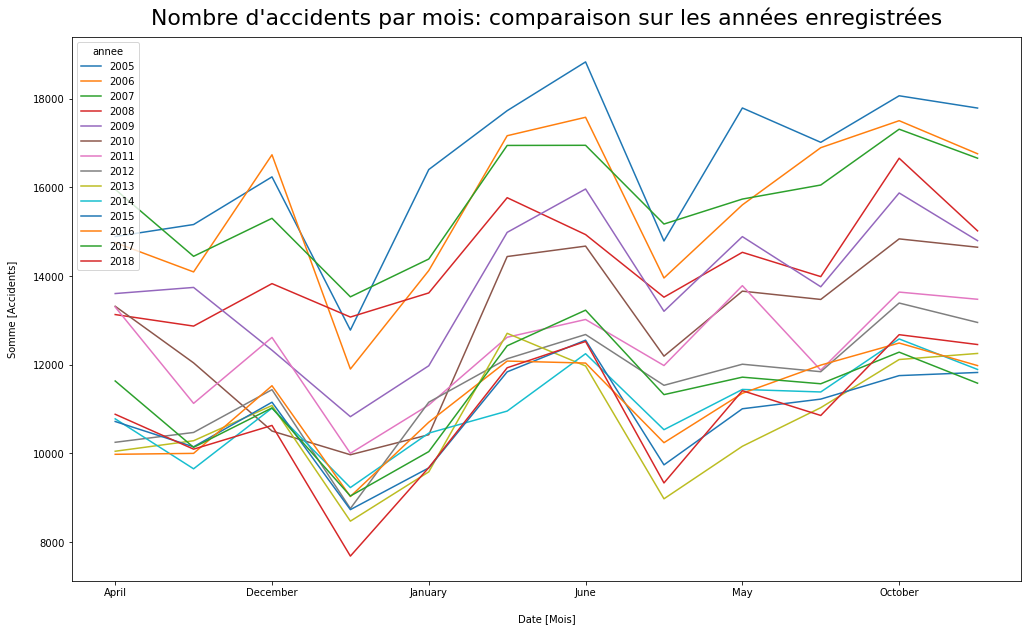

In [21]:


AccidentByMonth_pivoted.plot(kind='line', figsize=(17, 10))
plt.title("Nombre d'accidents par mois: comparaison sur les années enregistrées", y=1.013, fontsize=22)
plt.xlabel("Date [Mois]", labelpad=16)
plt.ylabel("Somme [Accidents]", labelpad=16); 

#### Exemple d'interraction

In [22]:
# x=(début, fin , step)
# Possibilité de mettre plusiers
@interact(annee=(2005,2018,1),
         mois=['Janv', 'Févr', 'Mars', 'Avr', 'Mai', 'Juin', 'Jull', 'Août', 'Sept', 'Oct', 'Nov', 'Déc'])
def monthFilter(annee=(2005), mois='Jan'):
    return AccidentByMonth.loc[(AccidentByMonth['annee'] > annee) & (AccidentByMonth['mois'] == mois)]  #Apply filter here

interactive(children=(IntSlider(value=2005, description='annee', max=2018, min=2005), Dropdown(description='mo…

In [23]:
AccidentByDay = pd.DataFrame({'Date' :  df_acc_usr['Date']  , 'nbr' : 1})
AccidentByDay['day'] = pd.to_datetime(((df_acc_usr['Date'].dt.year).map(str) 
                                         + (df_acc_usr['Date'].dt.month).map(str)
                                         + (df_acc_usr['Date'].dt.day).map(str)) 
                                        , format='%Y%m%d')

AccidentByDay = AccidentByDay.groupby('day' , as_index=False)['nbr'].sum()

AccidentByDay

@interact(start_date=widgets.DatePicker(value=pd.to_datetime('2005-01-01'))
                ,end_date=widgets.DatePicker(value=pd.to_datetime('2018-12-31')))
         
def monthFilter(jour=('2005-01-01')):
    return AccidentByDay.loc[(AccidentByDay['day'] > jour)]  #Apply filter here

interactive(children=(Text(value='2005-01-01', description='jour'), Output()), _dom_classes=('widget-interact'…

In [24]:
def print_articles_published(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    stat_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    total_words = stat_df['word_count'].sum()
    total_read_time = stat_df['read_time'].sum()
    num_articles = len(stat_df)
    print(f'You published {num_articles} articles between {start_date.date()} and {end_date.date()}.')
    print(f'These articles totalled {total_words:,} words and {total_read_time/60:.2f} hours to read.')
    


In [25]:
interact(
             start_date=widgets.DatePicker(value=pd.to_datetime('2005-01-01')),
        end_date=widgets.DatePicker(value=pd.to_datetime('2018-12-31')))

In [26]:
widget.DatePicker(description='Date Of Birth', disabled=False)

DatePicker(value=None, description='Date Of Birth')

In [27]:
AccidentByDay

,day,nbr
0,2005-01-01,465
1,2005-01-02,416
2,2005-01-03,534
3,2005-01-04,612
4,2005-01-05,613
...,...,...
4856,2018-12-27,250
4857,2018-12-28,276
4858,2018-12-29,268
4859,2018-12-30,210
